1. ~~Build LeNet5~~
2. ~~Train LeNet5 on MNIST~~

  * Adam
  * Schedule Decay Learning
    
3. ~~Train LeNet on CIFAR10~~
4. ~~Build AlexNet~~
5. ~~Build VGG16~~
6. ~~Build mini-VGG~~
7. Train mini-VGG16 on CIFAR10

  * Adam
  * lr_init = 0.01
  * lr = lr / 10 if val_loss doesn't improve
  * Regularization

# Import

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, AveragePooling2D, Dense, Flatten,
                                     InputLayer, BatchNormalization, Dropout,
                                     MaxPooling2D, Activation)
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import numpy as np
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

# Ex 01: Build LeNet5

In [2]:
def LeNet5(input_shape, num_classes):
    model = Sequential()

    # Input layer
    model.add(InputLayer(input_shape))

    # C1 Convolutional layer
    padding_c1 = 'same' if input_shape[:-1] == (28, 28) else 'valid'
    model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu', padding=padding_c1))

    # S2 Supsampling layer (pooling layer)
    model.add(AveragePooling2D())

    # C3 Convolutional layer
    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu', padding='valid'))

    # S4 Supsampling layer (pooling layer)
    model.add(AveragePooling2D())

    # C5 Convolutional layer
    model.add(Conv2D(filters=120, kernel_size=(5, 5), activation='relu', padding='valid'))

    model.add(Flatten(name='Flatten'))

    # FC6 Fully connected
    model.add(Dense(units=84, activation='relu'))

    # FC7 output
    model.add(Dense(units=num_classes, activation='softmax'))

    return model

lenet5 = LeNet5(input_shape=(28, 28, 1), num_classes=10)
lenet5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 120)         48120     
                                                                 
 Flatten (Flatten)           (None, 120)               0

# Ex 02: Train LeNet5 with MNIST

In [24]:
# Prepare MNIST data
(mnist_X_train, mnist_y_train), (mnist_X_test, mnist_y_test) = mnist.load_data()

# Image size and input size
image_size = mnist_X_train.shape[1:]

# Number of classes
num_labels = len(np.unique(mnist_y_train))

# Covert to one-hot
mnist_Y_train = to_categorical(mnist_y_train, num_labels)
mnist_Y_test = to_categorical(mnist_y_test, num_labels)

# Normalize data to range [0, 1]
mnist_X_train = mnist_X_train.astype('float32') / 255.0
mnist_X_test = mnist_X_test.astype('float32') / 255.0

# Split to validation set from train set
mnist_X_train, mnist_X_val = mnist_X_train[5000:, ...], mnist_X_train[:5000, ...]
mnist_Y_train, mnist_Y_val = mnist_Y_train[5000:, ...], mnist_Y_train[:5000, ...]

print('X_train.shape = ', mnist_X_train.shape)
print('Y_train.shape = ', mnist_Y_train.shape)
print('X_val.shape = ', mnist_X_val.shape)
print('Y_val.shape = ', mnist_Y_val.shape)
print('X_test.shape = ', mnist_X_test.shape)
print('Y_test.shape = ', mnist_Y_test.shape)

X_train.shape =  (55000, 28, 28)
Y_train.shape =  (55000, 10)
X_val.shape =  (5000, 28, 28)
Y_val.shape =  (5000, 10)
X_test.shape =  (10000, 28, 28)
Y_test.shape =  (10000, 10)


In [25]:
def scheduler(epoch, lr):
  if epoch < 2:
    lr = 5e-4
  elif epoch < 5:
    lr = 2e-4
  elif epoch < 9:
    lr = 5e-5
  else:
    lr = 1e-5
  return lr

lr_schedule = LearningRateScheduler(scheduler)

In [34]:
lenet5 = LeNet5(input_shape=mnist_X_train.shape[1:], num_classes=10)

adam = Adam()
lenet5.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='mnist.weights.best.hdf5',
                               verbose=1,
                               save_best_only=True)

callbacks = [checkpointer, lr_schedule]

hist = lenet5.fit(mnist_X_train, mnist_Y_train,
                 validation_data=(mnist_X_val, mnist_Y_val),
                 batch_size=500, epochs=50,
                 callbacks=callbacks,
                 verbose=1, shuffle=True)

Epoch 1/50
109/110 [============================>.] - ETA: 0s - loss: 1.1678 - accuracy: 0.6805
Epoch 1: val_loss improved from inf to 0.40521, saving model to mnist.weights.best.hdf5
110/110 [==============================] - 2s 8ms/step - loss: 1.1611 - accuracy: 0.6821 - val_loss: 0.4052 - val_accuracy: 0.8818 - lr: 5.0000e-04
Epoch 2/50
106/110 [===========================>..] - ETA: 0s - loss: 0.3579 - accuracy: 0.8961
Epoch 2: val_loss improved from 0.40521 to 0.27294, saving model to mnist.weights.best.hdf5
110/110 [==============================] - 1s 6ms/step - loss: 0.3547 - accuracy: 0.8973 - val_loss: 0.2729 - val_accuracy: 0.9256 - lr: 5.0000e-04
Epoch 3/50
104/110 [===========================>..] - ETA: 0s - loss: 0.2680 - accuracy: 0.9220
Epoch 3: val_loss improved from 0.27294 to 0.23937, saving model to mnist.weights.best.hdf5
110/110 [==============================] - 1s 6ms/step - loss: 0.2675 - accuracy: 0.9223 - val_loss: 0.2394 - val_accuracy: 0.9346 - lr: 2.0000e

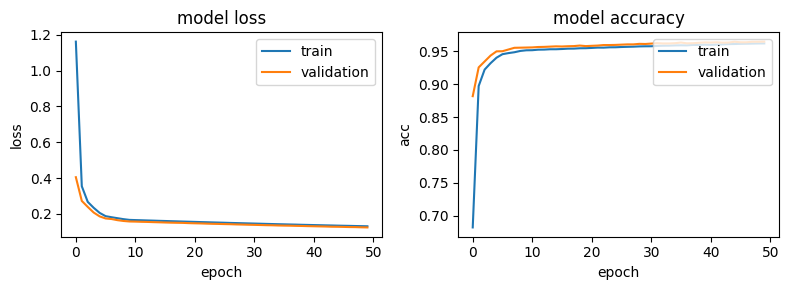

In [35]:
train_loss, val_loss = hist.history['loss'], hist.history['val_loss']
train_acc, val_acc = hist.history['accuracy'], hist.history['val_accuracy']

# Create a figure with two axes
fig, axs = plt.subplots(figsize=(8,3), nrows=1, ncols=2)

# Plot loss on the left axis
num_epochs = np.arange(len(train_loss))
axs[0].plot(num_epochs, train_loss)
axs[0].plot(num_epochs, val_loss)
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].set_title('model loss on MNIST')
axs[0].legend(['train', 'validation'], loc='upper right')

axs[1].plot(num_epochs, train_acc)
axs[1].plot(num_epochs, val_acc)
axs[1].set_ylabel('acc')
axs[1].set_xlabel('epoch')
axs[1].set_title('model accuracy on MNIST')
axs[1].legend(['train', 'validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [36]:
# Evaluate
lenet5.load_weights('./mnist.weights.best.hdf5')
score = lenet5.evaluate(mnist_X_test, mnist_Y_test, verbose=0)

print(f"Test accuracy: {score[1] * 100}%")

Test accuracy: 96.53000235557556%


# Ex 03: Train LeNet5 with CIFAR10

In [7]:
# Load CIFAR10 dataset
(cifar_X_train, cifar_y_train), (cifar_X_test, cifar_y_test) = cifar10.load_data()

# Normalizing between 0 and 1
cifar_X_train = cifar_X_train / 255.0
cifar_X_test = cifar_X_test / 255.0
#plt.imshow(x_train[0])


# Find num_of_classes and converting to one-hot
num_classes = len(np.unique(cifar_y_train))
cifar_Y_train = to_categorical(cifar_y_train, num_classes)
cifar_Y_test = to_categorical(cifar_y_test, num_classes)

# Split to validation set from train set
cifar_X_train, cifar_X_val = cifar_X_train[5000:, ...], cifar_X_train[:5000, ...]
cifar_Y_train, cifar_Y_val = cifar_Y_train[5000:, ...], cifar_Y_train[:5000, ...]

print(f"X_train.shape: {cifar_X_train.shape}")
print(f"Y_train.shape: {cifar_Y_train.shape}")
print(f"X_val.shape: {cifar_X_val.shape}")
print(f"Y_val.shape: {cifar_Y_val.shape}")
print(f"X_val.shape: {cifar_X_test.shape}")
print(f"Y_val.shape: {cifar_Y_test.shape}")

X_train.shape: (45000, 32, 32, 3)
Y_train.shape: (45000, 10)
X_val.shape: (5000, 32, 32, 3)
Y_val.shape: (5000, 10)
X_val.shape: (10000, 32, 32, 3)
Y_val.shape: (10000, 10)


In [5]:
lenet5 = LeNet5(input_shape=cifar_X_train.shape[1:], num_classes=10)
lenet5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 6)         456       
                                                                 
 average_pooling2d_4 (Avera  (None, 14, 14, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_5 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_8 (Conv2D)           (None, 1, 1, 120)         48120     
                                                                 
 Flatten (Flatten)           (None, 120)              

In [8]:
adam = Adam()
lenet5.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='cifar.weights.best.hdf5',
                               verbose=1,
                               save_best_only=True)

callbacks = [checkpointer]

hist = lenet5.fit(cifar_X_train, cifar_Y_train,
                 validation_data=(cifar_X_val, cifar_Y_val),
                 batch_size=500, epochs=50,
                 callbacks=callbacks,
                 verbose=1, shuffle=True)

Epoch 1/50
87/90 [============================>.] - ETA: 0s - loss: 1.9984 - accuracy: 0.2717
Epoch 1: val_loss improved from inf to 1.77043, saving model to cifar.weights.best.hdf5
90/90 [==============================] - 6s 13ms/step - loss: 1.9912 - accuracy: 0.2747 - val_loss: 1.7704 - val_accuracy: 0.3616
Epoch 2/50
16/90 [====>.........................] - ETA: 0s - loss: 1.7540 - accuracy: 0.3692

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/90 [===========================>..] - ETA: 0s - loss: 1.6898 - accuracy: 0.3921
Epoch 2: val_loss improved from 1.77043 to 1.64026, saving model to cifar.weights.best.hdf5
90/90 [==============================] - 1s 8ms/step - loss: 1.6868 - accuracy: 0.3936 - val_loss: 1.6403 - val_accuracy: 0.4142
Epoch 3/50
89/90 [============================>.] - ETA: 0s - loss: 1.5737 - accuracy: 0.4388
Epoch 3: val_loss improved from 1.64026 to 1.53560, saving model to cifar.weights.best.hdf5
90/90 [==============================] - 1s 9ms/step - loss: 1.5725 - accuracy: 0.4388 - val_loss: 1.5356 - val_accuracy: 0.4466
Epoch 4/50
90/90 [==============================] - ETA: 0s - loss: 1.4982 - accuracy: 0.4654
Epoch 4: val_loss improved from 1.53560 to 1.47040, saving model to cifar.weights.best.hdf5
90/90 [==============================] - 1s 9ms/step - loss: 1.4982 - accuracy: 0.4654 - val_loss: 1.4704 - val_accuracy: 0.4790
Epoch 5/50
88/90 [============================>.] - ETA: 0s - loss

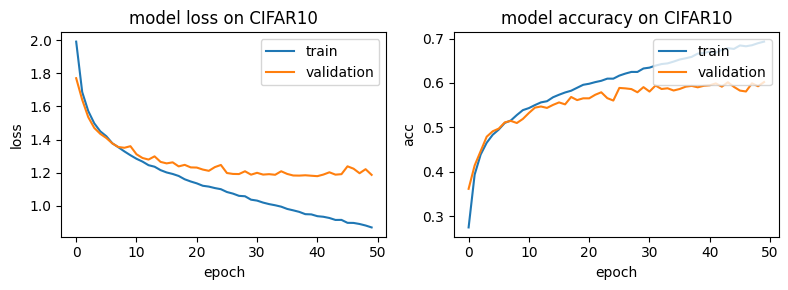

In [9]:
train_loss, val_loss = hist.history['loss'], hist.history['val_loss']
train_acc, val_acc = hist.history['accuracy'], hist.history['val_accuracy']

# Create a figure with two axes
fig, axs = plt.subplots(figsize=(8,3), nrows=1, ncols=2)

# Plot loss on the left axis
num_epochs = np.arange(len(train_loss))
axs[0].plot(num_epochs, train_loss)
axs[0].plot(num_epochs, val_loss)
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].set_title('model loss on CIFAR10')
axs[0].legend(['train', 'validation'], loc='upper right')

axs[1].plot(num_epochs, train_acc)
axs[1].plot(num_epochs, val_acc)
axs[1].set_ylabel('acc')
axs[1].set_xlabel('epoch')
axs[1].set_title('model accuracy on CIFAR10')
axs[1].legend(['train', 'validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [11]:
# Evaluate
lenet5.load_weights('./cifar.weights.best.hdf5')
score = lenet5.evaluate(cifar_X_test, cifar_Y_test, verbose=0)

print(f"Test accuracy: {score[1] * 100}%")

Test accuracy: 58.09999704360962%


# Ex 04: Build AlexNet

In [ ]:
def AlexNet(input_shape, num_classes):
    model = Sequential()

    # Input layer
    model.add(InputLayer(input_shape=input_shape))

    # Tầng 1 Convolutional Layer
    model.add(Conv2D(filters=96, kernel_size=11, strides=4, activation='relu'))
    model.add(MaxPooling2D(pool_size=3, strides=2))
    #model.add(BatchNormalization())

    # Tầng 2 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=5, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=3, strides=2))
    #model.add(BatchNormalization())

    # Tầng 3 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'))
    #model.add(BatchNormalization())

    # Tầng 4 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'))
    #model.add(BatchNormalization())

    # Tầng 5 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=3, strides=2))

    model.add(Flatten(name='Flatten'))

    # Tầng 6 FC
    model.add(Dense(units=4096, activation='relu'))
    #model.add(Dropout(rate=0.2))

    # Tầng 7 FC
    model.add(Dense(units=4096, activation='relu'))
    #model.add(Dropout(rate=0.2))

    # Tầng 8 FC
    model.add(Dense(units=num_classes, activation='softmax'))

    return model

model = AlexNet(input_shape=(227, 227, 3), num_classes=1000)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 27, 27, 96)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 13, 13, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 13, 13, 384)       885120    
                                                                 
 conv2d_36 (Conv2D)          (None, 13, 13, 384)     

# Ex 05: Build VGG16

In [ ]:
def VGG16(input_shape, num_classes):
    model = Sequential()

    # Input layer
    model.add(InputLayer(input_shape=input_shape))

    # Khối VGG 1
    model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=2, strides=2))

    # Khối VGG 2
    model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=2, strides=2))

    # Khối VGG 3
    model.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
    model.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
    model.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=2, strides=2))

    # Khối VGG 4
    model.add(Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'))
    model.add(Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'))
    model.add(Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=2, strides=2))

    # Khối VGG 5
    model.add(Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'))
    model.add(Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'))
    model.add(Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=2, strides=2))

    model.add(Flatten())

    # FC 1
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(rate=0.2))

    # FC 2
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(rate=0.2))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

model = VGG16(input_shape=(224, 224, 3), num_classes=1000)
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_65 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_66 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_67 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 56, 56, 128)       0         
 ng2D)                                               

# Ex 06: Build mini-VGG

In [22]:
def MiniVGG(input_shape, num_classes):
    model = Sequential()

    # Input layer
    model.add(InputLayer(input_shape=input_shape))

    # Block vgg 1
    model.add(Conv2D(filters=32, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())

    # Block vgg 2
    model.add(Conv2D(filters=64, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())

    model.add(Flatten(name='Flatten'))

    # FC 1
    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(rate=0.5))

    # FC 2
    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(rate=0.5))

    # FC 3 (output)
    model.add(Dense(units=num_classes, activation='softmax'))

    return model

model = MiniVGG(input_shape=(32, 32, 3), num_classes=10)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_8 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 activation_8 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_9 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 activation_9 (Activation)   (None, 32, 32, 32)       

# Ex 07: Train mini-VGG on CIFAR10

In [28]:
# Load CIFAR10 dataset
(cifar_X_train, cifar_y_train), (cifar_X_test, cifar_y_test) = cifar10.load_data()

# Normalizing between 0 and 1
cifar_X_train = cifar_X_train / 255.0
cifar_X_test = cifar_X_test / 255.0
#plt.imshow(x_train[0])


# Find num_of_classes and converting to one-hot
num_classes = len(np.unique(cifar_y_train))
cifar_Y_train = to_categorical(cifar_y_train, num_classes)
cifar_Y_test = to_categorical(cifar_y_test, num_classes)

# Split to validation set from train set
cifar_X_train, cifar_X_val = cifar_X_train[5000:, ...], cifar_X_train[:5000, ...]
cifar_Y_train, cifar_Y_val = cifar_Y_train[5000:, ...], cifar_Y_train[:5000, ...]

print(f"X_train.shape: {cifar_X_train.shape}")
print(f"Y_train.shape: {cifar_Y_train.shape}")
print(f"X_val.shape: {cifar_X_val.shape}")
print(f"Y_val.shape: {cifar_Y_val.shape}")
print(f"X_test.shape: {cifar_X_test.shape}")
print(f"Y_test.shape: {cifar_Y_test.shape}")

X_train.shape: (45000, 32, 32, 3)
Y_train.shape: (45000, 10)
X_val.shape: (5000, 32, 32, 3)
Y_val.shape: (5000, 10)
X_test.shape: (10000, 32, 32, 3)
Y_test.shape: (10000, 10)


In [40]:
mini_vgg = MiniVGG(input_shape=cifar_X_train.shape[1:], num_classes=10)
mini_vgg.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_24 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_24 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_25 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_25 (Activation)  (None, 32, 32, 32)       

In [41]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)

In [42]:
adam = Adam(learning_rate=0.01)
mini_vgg.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='cifar_minivgg.weights.best.hdf5',
                               verbose=1,
                               save_best_only=True)

callbacks = [checkpointer, reduce_lr]

hist = mini_vgg.fit(cifar_X_train, cifar_Y_train,
                 validation_data=(cifar_X_val, cifar_Y_val),
                 batch_size=1000, epochs=100,
                 callbacks=callbacks,
                 verbose=1, shuffle=True)

Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 6.3221 - accuracy: 0.1032
Epoch 1: val_loss improved from inf to 2.30223, saving model to cifar_minivgg.weights.best.hdf5
45/45 [==============================] - 8s 102ms/step - loss: 6.3221 - accuracy: 0.1032 - val_loss: 2.3022 - val_accuracy: 0.0988 - lr: 0.0100
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 2.2972 - accuracy: 0.1047
Epoch 2: val_loss improved from 2.30223 to 2.23067, saving model to cifar_minivgg.weights.best.hdf5
45/45 [==============================] - 4s 91ms/step - loss: 2.2972 - accuracy: 0.1047 - val_loss: 2.2307 - val_accuracy: 0.1570 - lr: 0.0100
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 2.2741 - accuracy: 0.1202
Epoch 3: val_loss did not improve from 2.23067
45/45 [==============================] - 4s 89ms/step - loss: 2.2741 - accuracy: 0.1202 - val_loss: 2.2548 - val_accuracy: 0.1556 - lr: 0.0100
Epoch 4/100
45/45 [=======================

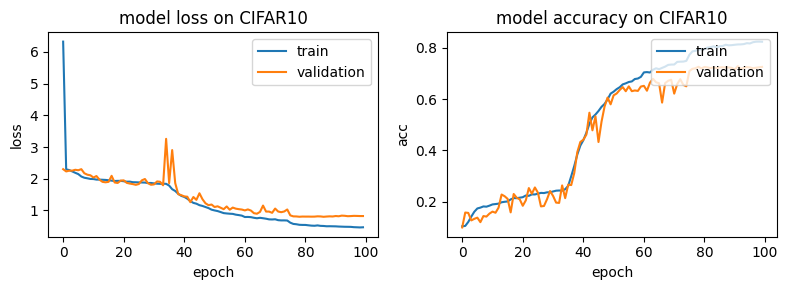

In [43]:
train_loss, val_loss = hist.history['loss'], hist.history['val_loss']
train_acc, val_acc = hist.history['accuracy'], hist.history['val_accuracy']

# Create a figure with two axes
fig, axs = plt.subplots(figsize=(8,3), nrows=1, ncols=2)

# Plot loss on the left axis
num_epochs = np.arange(len(train_loss))
axs[0].plot(num_epochs, train_loss)
axs[0].plot(num_epochs, val_loss)
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].set_title('model loss on CIFAR10')
axs[0].legend(['train', 'validation'], loc='upper right')

axs[1].plot(num_epochs, train_acc)
axs[1].plot(num_epochs, val_acc)
axs[1].set_ylabel('acc')
axs[1].set_xlabel('epoch')
axs[1].set_title('model accuracy on CIFAR10')
axs[1].legend(['train', 'validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [44]:
# Evaluate
mini_vgg.load_weights('./cifar_minivgg.weights.best.hdf5')
score = mini_vgg.evaluate(cifar_X_test, cifar_Y_test, verbose=0)

print(f"Test accuracy: {score[1] * 100}%")

Test accuracy: 72.18000292778015%


## Talk about

Simultaneously code and read the model architecture (one time)

How to use google, chatgpt

Train 3 times => Get marks in these trains

Asking them to record while coding